In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from astropy import constants as const
from astropy import units as u

In [6]:


#
# load up the ionization data from HW 2010
#
ionization_data = np.genfromtxt('HW2010_table1_ionization_rates_energy.dat',
                                skip_header=5,
                                dtype= [('mass','f8'),
                                        ('E_HI'  ,'f8'), ('N_HI'  ,'f8'),('lambda_HI'  ,'f8'),
                                        ('E_HeI' ,'f8'), ('N_HeI' ,'f8'),('lambda_HeI' ,'f8'),
                                        ('E_HeII','f8'), ('N_HeII','f8'),('lambda_HeII','f8'),
                                        ('E_LW'  ,'f8'), ('N_LW'  ,'f8'),('lambda_LW'  ,'f8'),                                        
                                       ]                              
                               )

colors = { 'HI' : 'C0', 'HeI' : 'C1', 'HeII' : 'C2'}

In [28]:
# from pop3_properties.F in Enzo

popIII_lifetimes = np.array([6.190e7,4.536e7,3.366e7,2.560e7,
          2.022e7,1.673e7,1.443e7,1.288e7,
          1.181e7,1.102e7,1.040e7,9.853e6,
          9.357e6,8.907e6,8.494e6,8.114e6,
          7.762e6,7.432e6,7.122e6,6.829e6,
          6.549e6,6.281e6,6.024e6,5.779e6,
          5.548e6,5.329e6,5.124e6,4.931e6,
          4.752e6,4.587e6,4.434e6,4.294e6,
          4.168e6,4.054e6,3.953e6,3.864e6,
          3.788e6,3.723e6,3.668e6,3.622e6,
          3.585e6,3.554e6,3.529e6,3.510e6,
          3.496e6,3.486e6,3.480e6,3.476e6,
          3.474e6,3.473e6,3.473e6,3.474e6,
          3.474e6,3.472e6,3.469e6,3.464e6,
          3.456e6,3.444e6,3.431e6,3.414e6,
          3.396e6,3.376e6,3.354e6,3.331e6,
          3.306e6,3.280e6,3.254e6,3.227e6,
          3.199e6,3.172e6,3.144e6,3.117e6,
          3.090e6,3.063e6,3.037e6,3.012e6,
          2.988e6,2.965e6,2.943e6,2.921e6,
          2.901e6,2.881e6,2.863e6,2.844e6,
          2.827e6,2.811e6,2.795e6,2.779e6,
          2.765e6,2.751e6,2.737e6,2.724e6,
          2.712e6,2.700e6,2.688e6,2.677e6,
          2.667e6,2.656e6,2.647e6,2.637e6,
          2.628e6,2.619e6,2.611e6,2.603e6,
          2.595e6,2.587e6,2.580e6,2.573e6,
          2.566e6,2.559e6,2.552e6,2.546e6,
          2.539e6,2.533e6,2.527e6,2.521e6,
          2.515e6,2.509e6,2.503e6,2.498e6,
          2.492e6,2.486e6,2.481e6,2.475e6,
          2.470e6,2.464e6,2.459e6,2.454e6,
          2.448e6,2.443e6,2.438e6,2.433e6,
          2.428e6,2.423e6,2.418e6,2.414e6,
          2.409e6,2.404e6,2.400e6,2.395e6,
          2.390e6,2.386e6,2.381e6,2.377e6,
          2.373e6,2.368e6,2.364e6,2.360e6,
          2.356e6,2.352e6,2.348e6,2.344e6,
          2.340e6,2.336e6,2.332e6,2.328e6,
          2.324e6,2.320e6,2.317e6,2.313e6,
          2.309e6,2.306e6,2.302e6,2.299e6,
          2.295e6,2.292e6,2.288e6,2.285e6,
          2.282e6,2.278e6,2.275e6,2.272e6,
          2.269e6,2.266e6,2.262e6,2.259e6,
          2.256e6,2.253e6,2.250e6,2.247e6,
          2.244e6,2.242e6,2.239e6,2.236e6,
          2.233e6,2.230e6,2.228e6,2.225e6,
          2.222e6,2.219e6,2.217e6,2.214e6,
          2.212e6,2.209e6,2.207e6,2.204e6,
          2.202e6,2.199e6,2.197e6,2.194e6,
          2.192e6,2.189e6,2.187e6,2.185e6,
          2.182e6,2.180e6,2.178e6,2.176e6,
          2.174e6,2.171e6,2.169e6,2.167e6,
          2.165e6,2.163e6,2.161e6,2.159e6,
          2.157e6,2.155e6,2.153e6,2.151e6,
          2.149e6,2.147e6,2.145e6,2.143e6,
          2.141e6,2.139e6,2.137e6,2.135e6,
          2.134e6,2.132e6,2.130e6,2.128e6,
          2.127e6,2.125e6,2.123e6,2.122e6,
          2.120e6,2.118e6,2.117e6,2.115e6,
          2.113e6,2.112e6,2.110e6,2.109e6,
          2.107e6,2.106e6,2.104e6,2.103e6,
          2.101e6,2.100e6,2.098e6,2.097e6,
          2.095e6,2.094e6,2.093e6,2.091e6,
          2.090e6,2.088e6,2.087e6,2.086e6,
          2.085e6,2.083e6,2.082e6,2.081e6,
          2.079e6,2.078e6,2.077e6,2.076e6,
          2.075e6,2.073e6,2.072e6,2.071e6,
          2.070e6,2.069e6,2.068e6,2.066e6,
          2.065e6,2.064e6,2.063e6,2.062e6,
          2.061e6,2.060e6,2.059e6,2.058e6,
          2.057e6,2.056e6,2.055e6,2.054e6,
          2.053e6,2.052e6,2.051e6,2.050e6,
          2.049e6,2.048e6,2.047e6,2.046e6,
          2.045e6,2.044e6,2.043e6,2.042e6,
          2.041e6,2.041e6,2.040e6,2.039e6,
          2.038e6,2.037e6,2.036e6,2.035e6,
          2.035e6,2.034e6,2.033e6,2.032e6,
          2.031e6,2.030e6,2.030e6,2.029e6,
          2.028e6,2.027e6,2.027e6,2.026e6,
          2.025e6,2.024e6,2.023e6,2.023e6,
          2.022e6,2.021e6,2.020e6,2.020e6,
          2.019e6,2.018e6,2.018e6,2.017e6,
          2.016e6,2.015e6,2.015e6,2.014e6,
          2.013e6,2.013e6,2.012e6,2.011e6,
          2.011e6,2.010e6,2.009e6,2.009e6,
          2.008e6,2.007e6,2.006e6,2.006e6,
          2.005e6,2.004e6,2.004e6,2.003e6,
          2.002e6,2.002e6,2.001e6,2.001e6,
          2.000e6,1.999e6,1.999e6,1.998e6,
          1.997e6,1.997e6,1.996e6,1.995e6,
          1.995e6,1.994e6,1.993e6,1.993e6,
          1.992e6,1.991e6,1.991e6,1.990e6,
          1.989e6,1.989e6,1.988e6,1.987e6,
          1.987e6,1.986e6,1.986e6,1.985e6,
          1.984e6,1.984e6,1.983e6,1.982e6,
          1.982e6,1.981e6,1.980e6,1.980e6,
          1.979e6,1.978e6,1.977e6,1.977e6,
          1.976e6,1.975e6,1.975e6,1.974e6,
          1.973e6,1.973e6,1.972e6,1.971e6,
          1.970e6,1.970e6,1.969e6,1.968e6,
          1.968e6,1.967e6,1.966e6,1.965e6,
          1.965e6,1.964e6,1.963e6,1.962e6,
          1.962e6,1.961e6,1.960e6,1.959e6,
          1.959e6,1.958e6,1.957e6,1.956e6,
          1.956e6,1.955e6,1.954e6,1.953e6,
          1.953e6,1.952e6,1.951e6,1.950e6,
          1.950e6,1.949e6,1.948e6,1.947e6,
          1.946e6,1.946e6,1.945e6,1.944e6,
          1.943e6,1.943e6,1.942e6,1.941e6,
          1.940e6,1.940e6,1.939e6,1.938e6,
          1.937e6,1.936e6,1.936e6,1.935e6,
          1.934e6,1.933e6,1.933e6,1.932e6,
          1.931e6,1.930e6,1.929e6,1.929e6,
          1.928e6,1.927e6,1.926e6,1.926e6,
          1.925e6,1.924e6,1.923e6,1.922e6,
          1.922e6,1.921e6,1.920e6,1.919e6,
          1.919e6,1.918e6,1.917e6,1.916e6,
          1.916e6,1.915e6,1.914e6,1.913e6,
          1.913e6,1.912e6,1.911e6,1.910e6,
          1.910e6,1.909e6,1.908e6,1.908e6,
          1.907e6,1.906e6,1.905e6,1.905e6,
          1.904e6,1.903e6,1.903e6,1.902e6,
          1.901e6,1.900e6,1.900e6,1.899e6,
          1.898e6,1.898e6,1.897e6,1.896e6,
          1.896e6,1.895e6,1.894e6,1.894e6,
          1.893e6,1.892e6,1.892e6,1.891e6,
          1.890e6,1.890e6,1.889e6,1.888e6,
          1.888e6,1.887e6,1.886e6,1.886e6,
          1.885e6,1.884e6,1.884e6,1.883e6,
          1.883e6,1.882e6,1.881e6,1.881e6,
          1.880e6,1.880e6,1.879e6,1.878e6,
          1.878e6,1.877e6,1.877e6,1.876e6,
          1.875e6,1.875e6,1.874e6,1.874e6,
          1.873e6,1.873e6,1.872e6,1.871e6,
          1.871e6,1.870e6,1.870e6,1.869e6,
          1.869e6,1.868e6,1.868e6,1.867e6,
          1.867e6,1.866e6,1.865e6,1.865e6,
          1.864e6,1.864e6,1.863e6,1.863e6,
          1.862e6,1.862e6,1.861e6,1.861e6,
          1.860e6,1.860e6,1.859e6,1.859e6,
          1.858e6,1.858e6,1.857e6,1.857e6,
          1.856e6,1.856e6,1.855e6,1.855e6,
          1.854e6,1.854e6,1.853e6,1.853e6,
          1.853e6,1.852e6,1.852e6,1.851e6,
          1.851e6,1.850e6,1.850e6,1.849e6,
          1.849e6,1.848e6,1.848e6,1.848e6,
          1.847e6,1.847e6,1.846e6,1.846e6,
          1.845e6,1.845e6,1.845e6,1.844e6,
          1.844e6,1.843e6,1.843e6,1.843e6,
          1.842e6,1.842e6,1.841e6,1.841e6,
          1.841e6,1.840e6,1.840e6,1.839e6,
          1.839e6,1.839e6,1.838e6,1.838e6,
          1.837e6,1.837e6,1.837e6,1.836e6,
          1.836e6,1.836e6,1.835e6,1.835e6,
          1.834e6,1.834e6,1.834e6,1.833e6,
          1.833e6,1.833e6,1.832e6,1.832e6,
          1.832e6,1.831e6,1.831e6,1.831e6,
          1.830e6,1.830e6,1.830e6,1.829e6,
          1.829e6,1.829e6,1.828e6,1.828e6,
          1.828e6,1.827e6,1.827e6,1.827e6,
          1.826e6,1.826e6,1.826e6,1.826e6,
          1.825e6,1.825e6,1.825e6,1.824e6,
          1.824e6,1.824e6,1.824e6,1.823e6,
          1.823e6,1.823e6,1.822e6,1.822e6,
          1.822e6,1.822e6,1.821e6,1.821e6,
          1.821e6,1.820e6,1.820e6,1.820e6,
          1.820e6,1.819e6,1.819e6,1.819e6,
          1.819e6,1.818e6,1.818e6,1.818e6,
          1.818e6,1.817e6,1.817e6,1.817e6,
          1.817e6,1.816e6,1.816e6,1.816e6,
          1.816e6,1.815e6,1.815e6,1.815e6,
          1.815e6,1.815e6,1.814e6,1.814e6,
          1.814e6,1.814e6,1.813e6,1.813e6,
          1.813e6,1.813e6,1.813e6,1.812e6,
          1.812e6,1.812e6,1.812e6,1.812e6,
          1.811e6,1.811e6,1.811e6,1.811e6,
          1.811e6,1.810e6,1.810e6,1.810e6,
          1.810e6,1.810e6,1.810e6,1.809e6,
          1.809e6,1.809e6,1.809e6,1.809e6,
          1.808e6,1.808e6,1.808e6,1.808e6,
          1.808e6,1.808e6,1.807e6,1.807e6,
          1.807e6,1.807e6,1.807e6,1.807e6,
          1.807e6,1.806e6,1.806e6,1.806e6,
          1.806e6,1.806e6,1.806e6,1.805e6,
          1.805e6,1.805e6,1.805e6,1.805e6,
          1.805e6,1.805e6,1.805e6,1.804e6,
          1.804e6,1.804e6,1.804e6,1.804e6,
          1.804e6,1.804e6,1.803e6,1.803e6,
          1.803e6,1.803e6,1.803e6,1.803e6,
          1.803e6,1.803e6,1.803e6,1.802e6,
          1.802e6,1.802e6,1.802e6,1.802e6,
          1.802e6,1.802e6,1.802e6,1.802e6,
          1.801e6,1.801e6,1.801e6,1.801e6,
          1.801e6,1.801e6,1.801e6,1.801e6,
          1.801e6,1.801e6,1.801e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6]) # in yr
    
popIII_lifetime_masses = np.linspace(5,1000,np.size(popIII_lifetimes))    


def get_popIII_lifetime(m):
    """
    Interpolate popIII lifetime masses exactly as is done in pop3_maker.F
    
    returns lifetime in years
    """
    
    if np.size(m) > 1:
        lifetimes = np.zeros(np.size(m))
        
        for i,mass in enumerate(m):
            lifetimes[i] = popIII_lifetimes[np.argmin(np.abs(popIII_lifetime_masses-mass))]
        return lifetimes
    else:
        index = np.argmin(np.abs(popIII_lifetime_masses)-m)
        return popIII_lifetimes[index]
    

In [34]:
    
def schaerer_photon_rates(m, radtype):
    
    x  = np.log10(m)
    x2 = x*x
    
    rate = np.zeros(np.size(m))
    
    select = (m > 9.0)*(m<500.0)    
   
    if radtype == 'HI':
        rate[select]   = 10.0**(43.61 + 4.9*x[select]   - 0.83*x2[select])
    elif radtype == 'HeI':
        rate[select]   = 10.0**(42.51 + 5.69*x[select]-1.01*x2[select])
    elif radtype == 'HeII':
        rate[select] = 10.0**(26.71 + 18.14*x[select]-3.58*x2[select])
    elif radtype == 'LW':
        rate[select] = 10.0**(44.03 + 4.59*x[select] - 0.77*x2[select])
        
    select = (m > 5.0)*(m < 9.0)
    
    if radtype == 'HI':
        rate[select] = 10.0**(39.29+8.55*x[select])
    elif radtype=='HeI':
        rate[select] = 10.0**(29.24+18.49*x[select])
    elif radtype=='HeII':
        rate[select] = 10.0**(26.71+18.14*x[select]-3.58*x2[select])
    elif radtype=='LW':
        rate[select] = 10.0**(44.03+4.59*x[select]-0.77*x2[select])

    return rate

def schaerer_total_photons(m, radtype):
    """
    Combine schaerer rates with popIII lifetimes to get total count
    """
    
    return schaerer_photon_rates(m,radtype) * (get_popIII_lifetime(m)*u.yr).to('s').value


# not really from Schaerer but old energies we used:
schaerer_energy = {'HI' : 28.0, 'HeI' : 50.0, 'HeII' : 58.0, 'LW' : 12.8}

In [121]:
#
# model fits to Heger and Woosley 2010
#

# schaerer provides power law fits 


def HW_ionization_fits(m, radtype, deg = 2, masscut = 20, return_coef=False):
    result = np.zeros(np.size(m))

    all_coef = []
    
    x = ionization_data['mass']
    y = ionization_data['N_'+radtype]

    if np.size(m[m<masscut]) > 1:
        coeff = np.polyfit(np.log10(x[x<masscut]), np.log10(y[x<masscut]), deg = deg)
    
        log_m  = np.log10(m[m<masscut])
        for i,c in enumerate(coeff):
        
            result[m<masscut] += c * log_m**(deg-i)
            
        all_coef += [coeff]
        
    if np.size(m[m>=masscut]) > 1:
        coeff = np.polyfit(np.log10(x[x>=masscut]), np.log10(y[x>=masscut]), deg = deg)
    
        log_m  = np.log10(m[m>=masscut])
        for i,c in enumerate(coeff):
        
            result[m>=masscut] += c * log_m**(deg-i)   
            
        all_coef += [coeff]
    
    if return_coef:
        return 10.0**result, all_coef
    else:
        return 10.0**result
    
    

def HW_energy_fits(m, radtype, deg = 2, return_coef=False):
    
    x = ionization_data['mass']
    y = (const.h * const.c/(ionization_data['lambda_' + radtype]*u.Angstrom)).to('eV').value

    coeff = np.polyfit(np.log10(x), np.log10(y), deg = deg)
    
    log_m  = np.log10(m)
    result = np.zeros(np.size(m))
    for i,c in enumerate(coeff):
        
        result += c * log_m**(deg-i)
    
    if return_coef:
        return 10.0**result, coeff
    else:
        return 10.0**result

[]

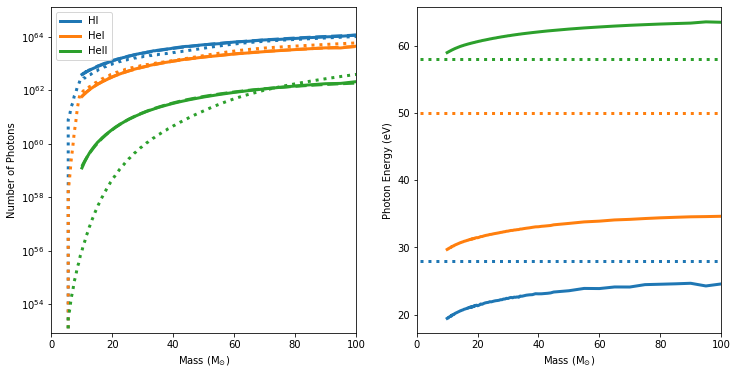

In [76]:

fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)


for radtype in ['HI','HeI','HeII']:
    ax[0].plot(ionization_data['mass'], 
               ionization_data['N_' + radtype], lw = 3, 
               color = colors[radtype], label = radtype)

    ax[0].plot(ionization_data['mass'], 
               HW_ionization_fits(ionization_data['mass'], radtype), lw = 3, 
               color = colors[radtype], ls = '--')
    
    # plot masses above and below
    #mass = np.linspace(5.0,10.0,20.0)
    #ax[0].plot(mass, 
    #           ionization_data['N_' + radtype][0] * mass / ionization_data['mass'][0], lw = 3, 
    #           color = colors[radtype], ls = '--')
    #mass = np.linspace(100.0,300.0,50.0)
    #ax[0].plot(mass, 
    #           ionization_data['N_' + radtype][-1] * mass / ionization_data['mass'][-1], lw = 3, 
    #           color = colors[radtype], ls = '--')
        
    
    mass = np.linspace(5.0,500.0,1000)    
    ax[0].plot(mass, schaerer_total_photons(mass, radtype),
               lw = 3, color = colors[radtype], ls = ':')
    
    photon_energy = (const.h * const.c/(ionization_data['lambda_' + radtype]*u.Angstrom)).to('eV')
    
    ax[1].plot(ionization_data['mass'], photon_energy.value, lw = 3,
               color = colors[radtype])
    
    mass = np.linspace(1.0,500.0,1000)
    ax[1].plot(mass, np.ones(np.size(mass))*schaerer_energy[radtype], 
               lw = 3, color = colors[radtype], ls = ':')    

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[0].set_ylabel(r'Number of Photons')
ax[1].set_ylabel(r'Photon Energy (eV)')


ax[0].legend(loc='best')

ax[0].semilogy()
#ax[0].semilogx()

Photons    HI 9.66E-03 2.79E-05 4.82E-02
Energy     HI 1.82E-03 5.85E-06 1.45E-02
Photons   HeI 7.37E-03 5.64E-06 5.25E-02
Energy    HeI 6.84E-04 6.15E-06 2.38E-03
Photons  HeII 7.50E-03 5.29E-05 3.94E-02
Energy   HeII 2.34E-04 8.13E-07 1.04E-03


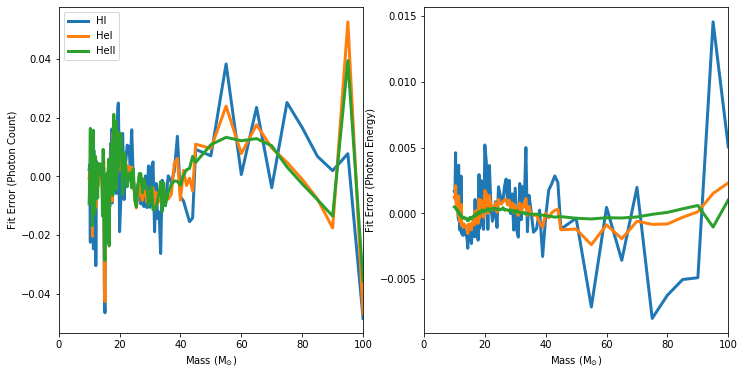

In [106]:

fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

deg = 3
masscut = 15.0

for radtype in ['HI','HeI','HeII']:
    
    fit_counts = HW_ionization_fits(ionization_data['mass'], radtype,
                                    deg = deg, masscut=masscut)
    N          = ionization_data['N_'+radtype]
    
    error = (fit_counts - N)/N
    abserror = np.abs(error)
    
    print("Photons %5s %5.2E %5.2E %5.2E"%(radtype, np.average(abserror), np.min(abserror), np.max(abserror)))
    
    ax[0].plot(ionization_data['mass'], 
               error, lw = 3, 
               color = colors[radtype], label = radtype)

    photon_energy = (const.h * const.c/(ionization_data['lambda_' + radtype]*u.Angstrom)).to('eV').value
    fit_energy = HW_energy_fits(ionization_data['mass'], radtype, deg = deg)
    
    error = (fit_energy - photon_energy)/photon_energy
    abserror = np.abs(error)
          
    print("Energy  %5s %5.2E %5.2E %5.2E"%(radtype, np.average(abserror), np.min(abserror), np.max(abserror)))
   
    ax[1].plot(ionization_data['mass'], error, lw = 3,
               color = colors[radtype])

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[0].set_ylabel(r'Fit Error (Photon Count)')
ax[1].set_ylabel(r'Fit Error (Photon Energy)')


ax[0].legend(loc='best')

#ax[0].semilogy()


In [102]:
samples  = np.arange(10.0,100.0,1.0)
maxerror = np.zeros(np.size(samples))    
maxavg   = np.zeros(np.size(samples))    

deg = 3

for i,masscut in enumerate(samples):
    
    for radtype in ['HI','HeI','HeII']:
        fit_counts = HW_ionization_fits(ionization_data['mass'], radtype,
                                        deg = deg, masscut=masscut)
        N          = ionization_data['N_'+radtype]
    
        error      = (fit_counts - N)/N
        abserror   = np.abs(error)
        
        maxerror[i]   = np.max( [maxerror[i],np.max(abserror)])
        maxavg[i]     += np.average(abserror)
        
    maxavg[i] = maxavg[i] / 3.0

best_model = np.argmin(maxerror)
print(samples[best_model])
print(maxerror[best_model])

best_model2 = np.argmin(maxavg)
print(samples[best_model])
print(maxavg[best_model])

15.0
0.05251204578072249
15.0
0.008176133778474178


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly conditioned
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RankWarning: Polyfit may be poorly cond

In [104]:
ionization_data['mass']

array([ 10. ,  10.2,  10.4,  10.5,  10.6,  10.7,  10.8,  10.9,  11. ,
        11.1,  11.2,  11.3,  11.4,  11.5,  11.6,  11.7,  11.8,  11.9,
        12. ,  12.2,  12.4,  12.6,  12.8,  13. ,  13.2,  13.4,  13.6,
        13.8,  14. ,  14.2,  14.4,  14.6,  14.8,  15. ,  15.2,  15.4,
        15.6,  15.8,  16. ,  16.2,  16.4,  16.6,  16.8,  17. ,  17.1,
        17.2,  17.3,  17.4,  17.5,  17.6,  17.7,  17.8,  17.9,  18. ,
        18.1,  18.2,  18.3,  18.4,  18.5,  18.6,  18.7,  18.8,  18.9,
        19. ,  19.2,  19.4,  19.6,  19.8,  20. ,  20.5,  21. ,  21.5,
        22. ,  22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,
        26.5,  27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,
        31. ,  31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,
        36. ,  37. ,  38. ,  39. ,  40. ,  41. ,  42. ,  43. ,  44. ,
        45. ,  50. ,  55. ,  60. ,  65. ,  70. ,  75. ,  80. ,  85. ,
        90. ,  95. , 100. ])

In [124]:
for radtype in ['HI','HeI','HeII']:
    vals, coef = HW_ionization_fits(ionization_data['mass'],
                   radtype,
                   deg = 3,
                   masscut = 15,
                   return_coef=True)
    
    print(radtype)
    print("pow(10.0, %5.4f*x3 + %5.4f*x2 + %5.4f*x + %5.4f);"%(coef[0][0],coef[0][1],coef[0][2],coef[0][3]))
    print("pow(10.0, %5.4f*x3 + %5.4f*x2 + %5.4f*x + %5.4f);"%(coef[1][0],coef[1][1],coef[1][2],coef[1][3]))
    print("-------------")
    
print("===========================")

for radtype in ['HI','HeI','HeII']:
    vals, coef = HW_energy_fits(ionization_data['mass'],
                   radtype,
                   deg = 3,
                   #masscut = 15,
                   return_coef=True)
    
    print(radtype)
    print("pow(10.0, %5.4f*x3 + %5.4f*x2 + %5.4f*x + %5.4f);"%(coef[0],coef[1],coef[2],coef[3]))
    #print("pow(10.0, %5.4f*x3 + %5.4f*x2 + %5.4f*x + %5.4f)"%(coef[1][0],coef[1][1],coef[1][2],coef[1][3]))
    print("-------------")    

HI
pow(10.0, 10.3574*x3 + -34.2086*x2 + 39.2123*x + 47.2375)
pow(10.0, 0.0809*x3 + -0.9734*x2 + 3.8892*x + 59.5187)
-------------
HeI
pow(10.0, 10.5994*x3 + -36.3156*x2 + 43.8303*x + 43.6579)
pow(10.0, 0.1045*x3 + -1.3872*x2 + 5.3264*x + 57.6942)
-------------
HeII
pow(10.0, 12.0633*x3 + -45.5716*x2 + 61.5720*x + 31.0292)
pow(10.0, 0.2993*x3 + -3.2414*x2 + 10.7515*x + 51.3787)
-------------
HI
pow(10.0, 0.0007*x3 + -0.0529*x2 + 0.2568*x + 1.0847)
-------------
HeI
pow(10.0, -0.0065*x3 + 0.0058*x2 + 0.0952*x + 1.3787)
-------------
HeII
pow(10.0, -0.0009*x3 + -0.0057*x2 + 0.0558*x + 1.7217)
-------------


In [123]:
coef

array([ 7.16938909e-04, -5.29348598e-02,  2.56835815e-01,  1.08469218e+00])